In [1]:
import numpy as np
import pandas as pd


In [2]:
from loadAndPreprocess import load_and_preprocess

well_info, _ = load_and_preprocess()

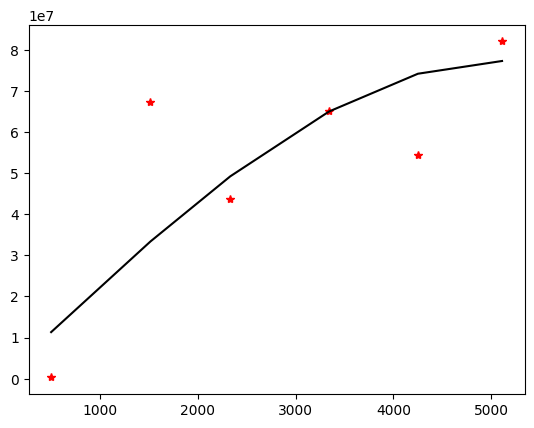

In [3]:
X = well_info['X']
Y = well_info['Y']

# Define grid points for interpolation
grid_x = np.arange(min(X)-200, max(X)+200, 2.0)
grid_y = np.arange(min(Y)-200, max(Y)+200, 2.0)

from pykrige.ok import OrdinaryKriging

values = (well_info['Total Resources'])

ok_res = OrdinaryKriging(
    X,
    Y,
    values,
    variogram_model='spherical',
    enable_plotting=True
)

# Perform the interpolation
z_res, ss_res = ok_res.execute('grid', grid_x, grid_y)

In [4]:
from scipy.spatial import distance_matrix
from scipy.optimize import differential_evolution
from scipy.interpolate import griddata
from pyswarm import pso

def objective_function_pso(new_wells, existing_wells, z_res, grid_x, grid_y):
    all_wells = np.vstack((existing_wells, new_wells.reshape(-1, 2)))
    dist_mat = distance_matrix(all_wells, all_wells)
    np.fill_diagonal(dist_mat, np.inf)
    min_distance = np.min(dist_mat)

    grid_points = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)
    z_values = z_res.ravel()
    resources_at_new_wells = griddata(grid_points, z_values, new_wells.reshape(-1, 2), method='linear')
    total_resources = np.sum(resources_at_new_wells)

    return -min_distance - total_resources

def optimize_well_placement_pso(existing_wells, num_new_wells, z_res, grid_x, grid_y):
    bounds = []
    x_min, y_min = np.min(existing_wells, axis=0)
    x_max, y_max = np.max(existing_wells, axis=0)
    extension = 0.1 * (x_max - x_min)
    for _ in range(num_new_wells):
        bounds.extend([(x_min - extension, x_max + extension), (y_min - extension, y_max + extension)])

    lb = [b[0] for b in bounds]
    ub = [b[1] for b in bounds]

    xopt, fopt = pso(
        objective_function_pso,
        lb,
        ub,
        args=(existing_wells, z_res, grid_x, grid_y),
        swarmsize=300,
        maxiter=1000
    )

    return xopt.reshape(-1, 2)


In [5]:

# Extract the existing well coordinates from the DataFrame
existing_wells = well_info[['X', 'Y']].values

# Number of new wells to add
num_new_wells = 5
new_wells = optimize_well_placement_pso(existing_wells, num_new_wells, z_res, grid_x, grid_y)
print("Optimal locations for new wells:")
print(new_wells)

KeyboardInterrupt: 

In [ ]:
# Plot the existing and new wells using plotly
import plotly.express as px
fig = px.scatter(title='Existing Wells')
fig.add_scatter(x=existing_wells[:, 0], y=existing_wells[:, 1],
                mode='markers', marker=dict(color='#1f77b4'), name='Exsiting Wells')
fig.add_scatter(x=new_wells[:, 0], y=new_wells[:, 1], mode='markers', marker=dict(color='#d62728'), name='New Wells')
fig.update_layout(
    height=600,
    width=700,
)
fig.show()